# Soft Actor-Critic

In statistical mechanics, entropy is a measure of the number of ways a system can be arranged, often taken to be a measure of "disorder" (the higher the entropy, the higher the disorder).
It is defined as:
$$H(p) = -\int P(x) log(P(x)) dx $$

For SAC, it introduced a extra term to regularize Q value. So instead of using the target value $r_t + \gamma (1-d_t)Q_\phi'$, SAC uses the target as $r_t + \gamma (1-d_t) (Q_\phi' + \alpha H(P))$, where $\alpha$ is the coefficient to weight entropy called entropy temperature.


In [72]:
import torch, random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import HTML
from cartpole_utils import env_cartpole, display_frames_as_gif, goalAchieved, test_cartpole

In [73]:
# networks

# Q value net
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, action_dim)

    def forward(self, state):
        out = torch.relu(self.fc1(state))
        out = self.fc2(out)
        return out
    
# policy net
class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, action_dim)

    def forward(self, state):
        out = torch.relu(self.fc1(state))
        logits = self.fc2(out)
        return logits

In [74]:
class ReplayMemory:
    def __init__(self, size):
        self.games = []
        self.size = size

    def add(self, attrib:list):
        if len(self) == self.size:
            self.games.pop(0)  # Remove the oldest sample if the memory is full.
        self.games.append(attrib)
        
    def __len__(self):
        return len(self.games)
    
    def clear(self):
        self.games.clear()
    
    def sample(self, batch_size):
        out = []
        samples = random.sample(self.games, batch_size)
        for i in range(len(samples[0])):
            tensor = torch.tensor([items[i] for items in samples])
            out.append(tensor)
        return out

In [75]:
class SACQAgent:
    def __init__(self):
        self.qvalues1 = QNet(4, 2)
        self.qvalues2 = QNet(4, 2)
        self.pvalues = PolicyNet(4, 2)
        self.qtargets1 = QNet(4, 2).requires_grad_(False)
        self.qtargets2 = QNet(4, 2).requires_grad_(False)
        self.opt_qvalues1 = torch.optim.AdamW(self.qvalues1.parameters(), lr=0.0005)
        self.opt_qvalues2 = torch.optim.AdamW(self.qvalues2.parameters(), lr=0.0005)
        self.opt_policy = torch.optim.AdamW(self.pvalues.parameters(), lr=0.0005)

        self.epsilon = 1.0 #exploration rate
        self.epsilon_decay = 1.0/(1000*80)
        self.epsilon_final = 0.1

    def act(self, state, train=True):
        if np.random.random() < self.epsilon and train:
            action = random.choice([0,1])
            return action
        if isinstance(state, np.ndarray):
            if len(state.shape) == 1:
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            else:
                state = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            action = self.pvalues(state).squeeze(-1)
            action = torch.multinomial(F.softmax(action), 1)
        return action.item()
    
    def update_epsilon(self):
        self.epsilon -= self.epsilon_decay
        if self.epsilon < self.epsilon_final:
            self.epsilon = self.epsilon_final
    
    def learn(self, plays, batch_size):
        gamma = 0.99
        alpha = 0.1

        # get data
        samples = plays.sample(batch_size)
        for sample in samples:
            if len(sample.shape) == 1:
                sample.unsqueeze_(-1)
        
        # get samples batch
        states, rewards, actions, states_next, dones = samples

        # critic
        with torch.no_grad():
            pi_target_next = self.pvalues(states_next)

            q_next1 = self.qtargets1(states_next)
            q_next2 = self.qtargets2(states_next)

            q_targets1 = q_next1.unsqueeze(1) @ (F.softmax(pi_target_next, dim=1)).unsqueeze(2)
            q_targets2 = q_next2.unsqueeze(1) @ (F.softmax(pi_target_next, dim=1)).unsqueeze(2)

            q_next_min = torch.minimum(q_targets1.squeeze(-1), q_targets2.squeeze(-1))

            h = F.softmax(pi_target_next, dim=1).unsqueeze(1) @ F.log_softmax(pi_target_next, dim=1).unsqueeze(2)
            h = -alpha * h.squeeze(-1)

            q_targets = rewards + (1.0 - dones) * gamma * (q_next_min + h)

        # crtic 1
        q_values1 = self.qvalues1(states)
        actions_one_hot = F.one_hot(actions, num_classes=2).to(torch.float).squeeze(1)
        q_values1 = q_values1.unsqueeze(1) @ actions_one_hot.unsqueeze(2)
        q_values1 = q_values1.squeeze(-1)
        q_loss1 = F.mse_loss(q_values1, q_targets, reduction='mean')

        self.opt_qvalues1.zero_grad()
        q_loss1.backward()
        self.opt_qvalues1.step()

        # crtic 2
        q_values2 = self.qvalues2(states)
        actions_one_hot = F.one_hot(actions, num_classes=2).to(torch.float).squeeze(1)
        q_values2 = q_values2.unsqueeze(1) @ actions_one_hot.unsqueeze(2)
        q_values2 = q_values2.squeeze(-1)
        q_loss2 = F.mse_loss(q_values2, q_targets, reduction='mean')

        self.opt_qvalues2.zero_grad()
        q_loss2.backward()
        self.opt_qvalues2.step()

        # actor
        pi_logits = self.pvalues(states)
        self.qvalues1.requires_grad_(False)
        q_values = self.qvalues1(states)
        esperance = F.softmax(pi_logits, dim=1).unsqueeze(1) @ (q_values - alpha * -F.log_softmax(pi_logits, dim=1)).unsqueeze(2)

        policy_loss = -esperance.squeeze(-1).mean()

        self.opt_policy.zero_grad()
        policy_loss.backward()
        self.opt_policy.step()

        self.qvalues1.requires_grad_(True)
        
        # update target networks
        self.update_target()
        self.update_epsilon()

        return q_loss1.detach().item(), policy_loss.detach().item()
    
    def update_target(self):
        tau = 0.002
        for target, source in zip(self.qtargets1.parameters(), self.qvalues1.parameters()):
            target.data.copy_(tau * source.data + (1.0 - tau) * target.data)

        for target, source in zip(self.qtargets2.parameters(), self.qvalues2.parameters()):
            target.data.copy_(tau * source.data + (1.0 - tau) * target.data)

In [76]:
# train loop

epochs = 2000
batch_size = 250
state_num = 4 # 
action_num = 2
memory = ReplayMemory(1000)
agent = SACQAgent()

scores = []
losses = []

for e in range(epochs):
    # reset environment
    state, _ = env_cartpole.reset()

    currState = state
    done = False

    score = 0
    tot_loss = [0., 0.]
    count = 0

    # run an episode
    while not done :
        
        # choose action
        action = int(agent.act(state))

        # take action on env
        state, reward, done, trunc, _ = env_cartpole.step(action)
        
        # add to replay memory
        memory.add([currState, reward, action, state, (1.0 if done else 0.0)])

        if len(memory) >= batch_size:
            # train the network
            qloss, ploss = agent.learn(memory, batch_size)
            tot_loss[0] += qloss
            tot_loss[1] += ploss
            count += 1

        currState = state.copy()
        # update score
        score += 1

        if score > 800:
            break
    
    scores = np.append(scores, score)
    tmp = [l/count if count > 0 else 0. for l in tot_loss]
    losses = np.append(losses, tmp)


    if (e+1)%100 == 0:
        print(f"epoche: {e+1}, score: {score}, qloss: {tot_loss[0]/count:.4f}, ploss: {tot_loss[1]/count:.4f}, epsilon: {agent.epsilon:.4f}")
    if goalAchieved(scores):
        break

/tmp/ipykernel_3031978/3427906256.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action = torch.multinomial(F.softmax(action), 1)


epoche: 100, score: 13, qloss: 0.0585, ploss: -3.2409, epsilon: 0.9777
epoche: 200, score: 13, qloss: 0.0519, ploss: -6.0091, epsilon: 0.9470
epoche: 300, score: 16, qloss: 0.1658, ploss: -7.3046, epsilon: 0.9172
epoche: 400, score: 46, qloss: 0.1950, ploss: -7.0619, epsilon: 0.8927
epoche: 500, score: 16, qloss: 0.2349, ploss: -7.5059, epsilon: 0.8679
epoche: 600, score: 12, qloss: 0.4629, ploss: -11.0532, epsilon: 0.8416
epoche: 700, score: 10, qloss: 0.3785, ploss: -8.6350, epsilon: 0.8163
epoche: 800, score: 64, qloss: 0.8247, ploss: -12.6116, epsilon: 0.7925
epoche: 900, score: 31, qloss: 1.3330, ploss: -26.7548, epsilon: 0.7442
epoche: 1000, score: 70, qloss: 2.3602, ploss: -32.5085, epsilon: 0.6924
epoche: 1100, score: 85, qloss: 3.5879, ploss: -40.7054, epsilon: 0.6254
epoche: 1200, score: 19, qloss: 6.1360, ploss: -47.9600, epsilon: 0.5493
epoche: 1300, score: 125, qloss: 8.0777, ploss: -59.5601, epsilon: 0.4154
epoche: 1400, score: 32, qloss: 0.2575, ploss: -61.7715, epsilon:

In [78]:
frames = test_cartpole(env_cartpole, 300, agent=agent)
anim = display_frames_as_gif(frames)
HTML(anim.to_jshtml())

/tmp/ipykernel_3031978/3427906256.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action = torch.multinomial(F.softmax(action), 1)


301


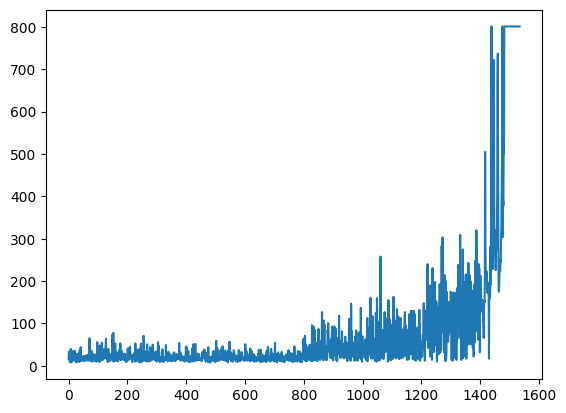

In [79]:
plt.plot(scores)